InvoiceNo	StockCode	Description	Quantity	InvoiceDate	UnitPrice	CustomerID	Country
536414	22139		56	2010-12-01 11:52:00.000000 UTC	0.0		United Kingdom
536545	21134		1	2010-12-01 14:32:00.000000 UTC	0.0		United Kingdom
536546	22145		1	2010-12-01 14:33:00.000000 UTC	0.0		United Kingdom
536547	37509		1	2010-12-01 14:33:00.000000 UTC	0.0		United Kingdom
536549	85226A		1	2010-12-01 14:34:00.000000 UTC	0.0		United Kingdom
536550	85044		1	2010-12-01 14:34:00.000000 UTC	0.0		United Kingdom
536552	20950		1	2010-12-01 14:34:00.000000 UTC	0.0		United Kingdom
536553	37461		3	2010-12-01 14:35:00.000000 UTC	0.0		United Kingdom
536554	84670		23	2010-12-01 14:35:00.000000 UTC	0.0		United Kingdom
536589	21777		-10	2010-12-01 16:50:00.000000 UTC	0.0		United Kingdom

In [ ]:
select * 
from first-metric-410915.modulabs_project.data
limit 10

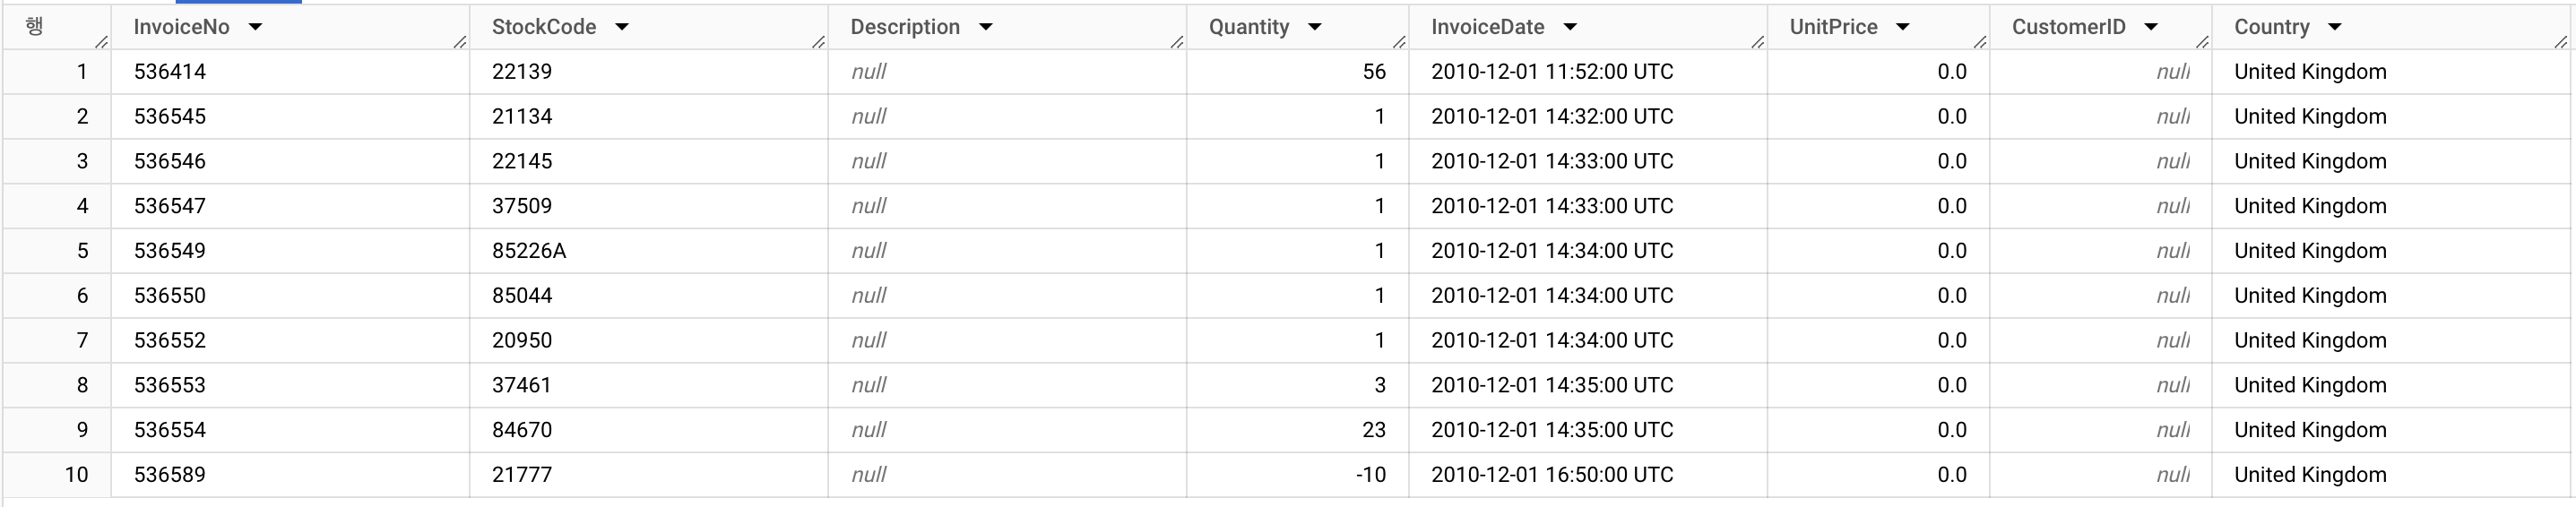

In [ ]:
SELECT COUNT(*) as total_rows
FROM first-metric-410915.modulabs_project.data

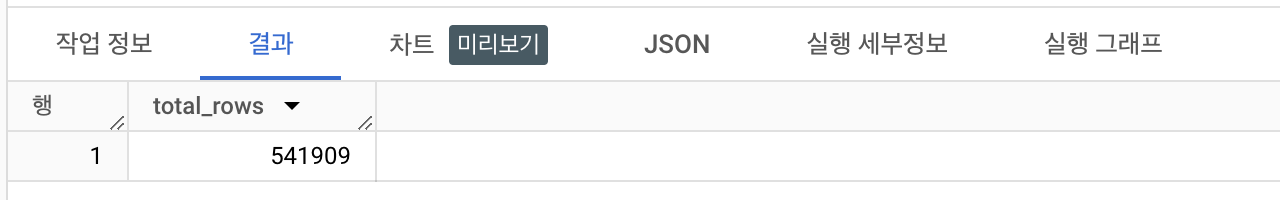

In [ ]:
# 결측치 비율 확인
SELECT COUNT(InvoiceNo) as COUNT_InvoiceNo, COUNT(StockCode) as COUNT_StockCode, COUNT(Description) as COUNT_Description, COUNT(Quantity) as COUNT_Quantity, COUNT(InvoiceDate) as COUNT_InvoiceDate, COUNT(UnitPrice) as COUNT_UnitPrice, COUNT(CustomerID) as COUNT_CustomerID, COUNT(Country) as COUNT_Country
FROM first-metric-410915.modulabs_project.data;

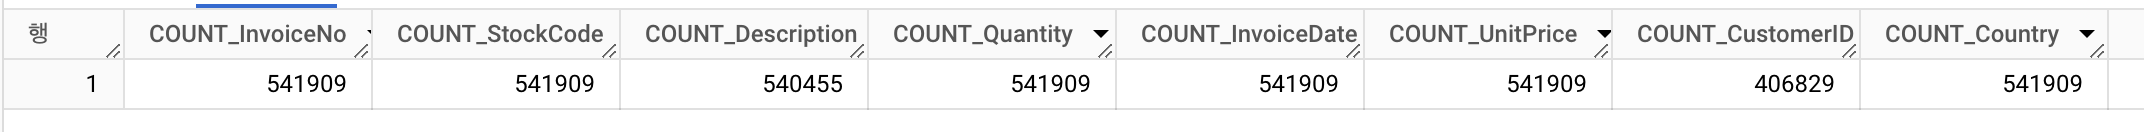

## 15-4 데이터 전처리(1) : 결측치 제거

In [ ]:
#  결측치 비율 확인
SELECT
    'InvoiceNo' AS column_name,
    ROUND(SUM(CASE WHEN InvoiceNo IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'StockCode' AS column_name,
    ROUND(SUM(CASE WHEN StockCode IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'Description' AS column_name,
    ROUND(SUM(CASE WHEN Description IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'Quantity' AS column_name,
    ROUND(SUM(CASE WHEN Quantity IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'InvoiceDate' AS column_name,
    ROUND(SUM(CASE WHEN InvoiceDate IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'UnitPrice' AS column_name,
    ROUND(SUM(CASE WHEN UnitPrice IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'CustomerID' AS column_name,
    ROUND(SUM(CASE WHEN CustomerID IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'Country' AS column_name,
    ROUND(SUM(CASE WHEN Country IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data

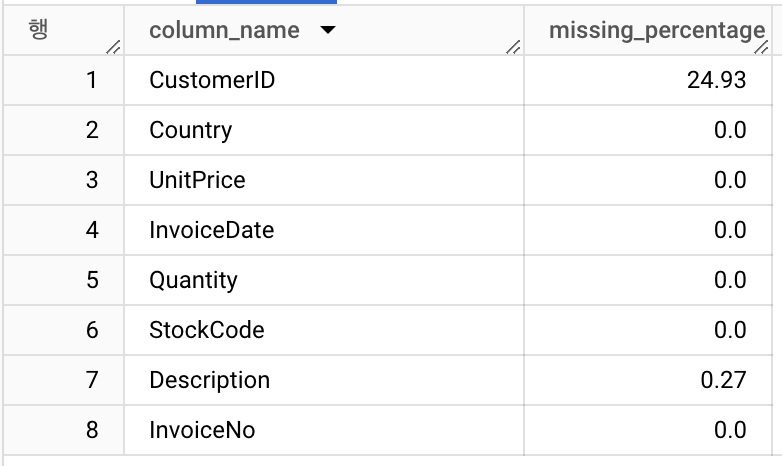

In [ ]:
# Description 확인
SELECT DISTINCT Description
FROM first-metric-410915.modulabs_project.data
WHERE StockCode = '85123A'

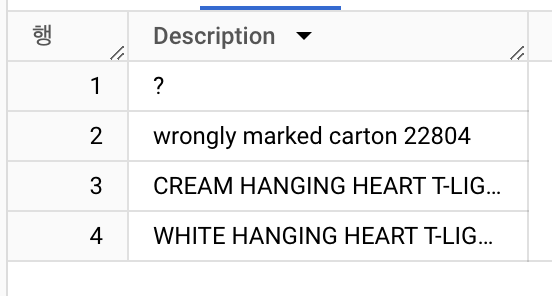

In [ ]:
# 결측치 처리
DELETE FROM first-metric-410915.modulabs_project.data
WHERE Description IS NULL 
OR CustomerID IS NULL;

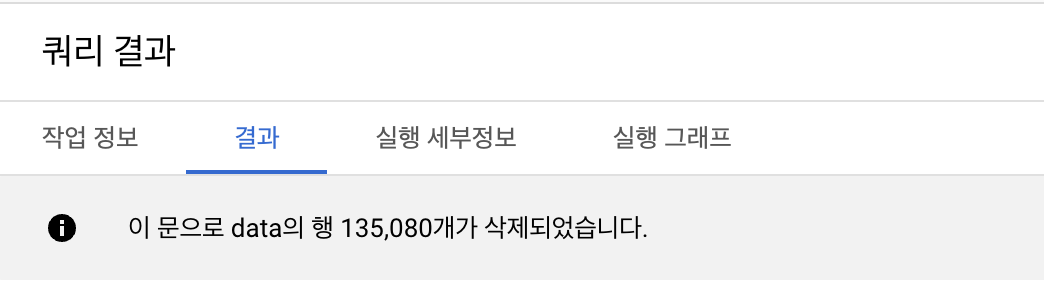

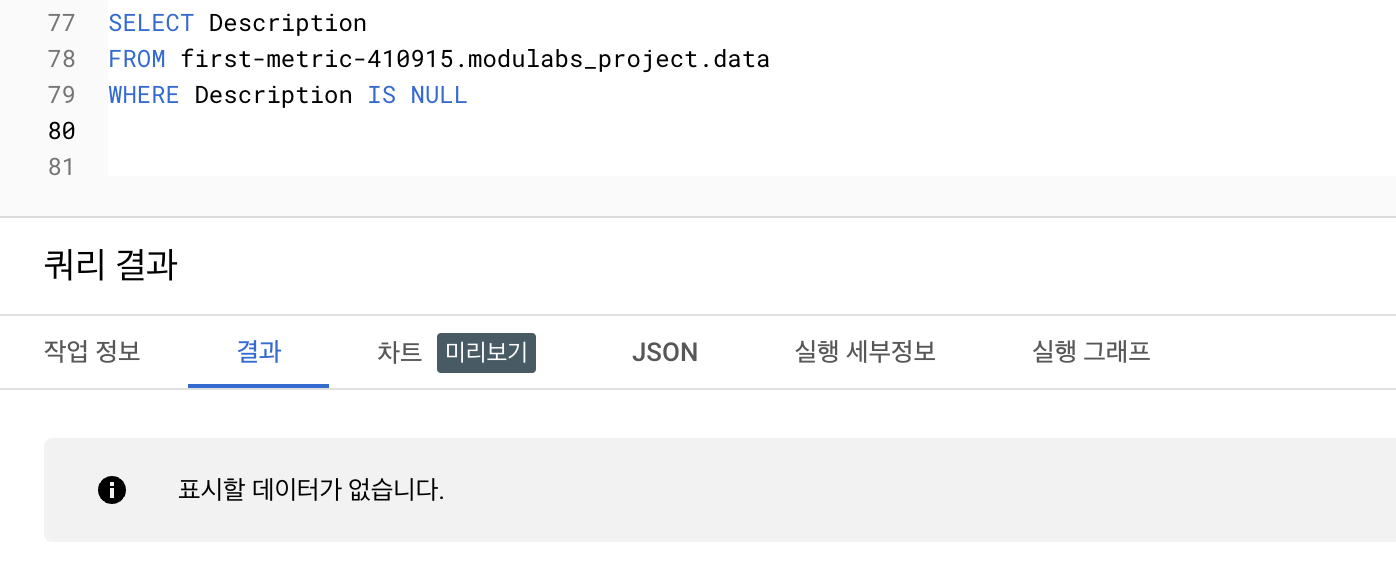

## 15-5. 데이터 전처리(2): 중복값 처리

In [ ]:
# 중복값 확인
WITH DUPLICATE AS (
  SELECT InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, COUNT(*) as row_count
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1,2,3,4,5,6,7,8
)
SELECT *
FROM DUPLICATE
WHERE DUPLICATE.row_count > 1

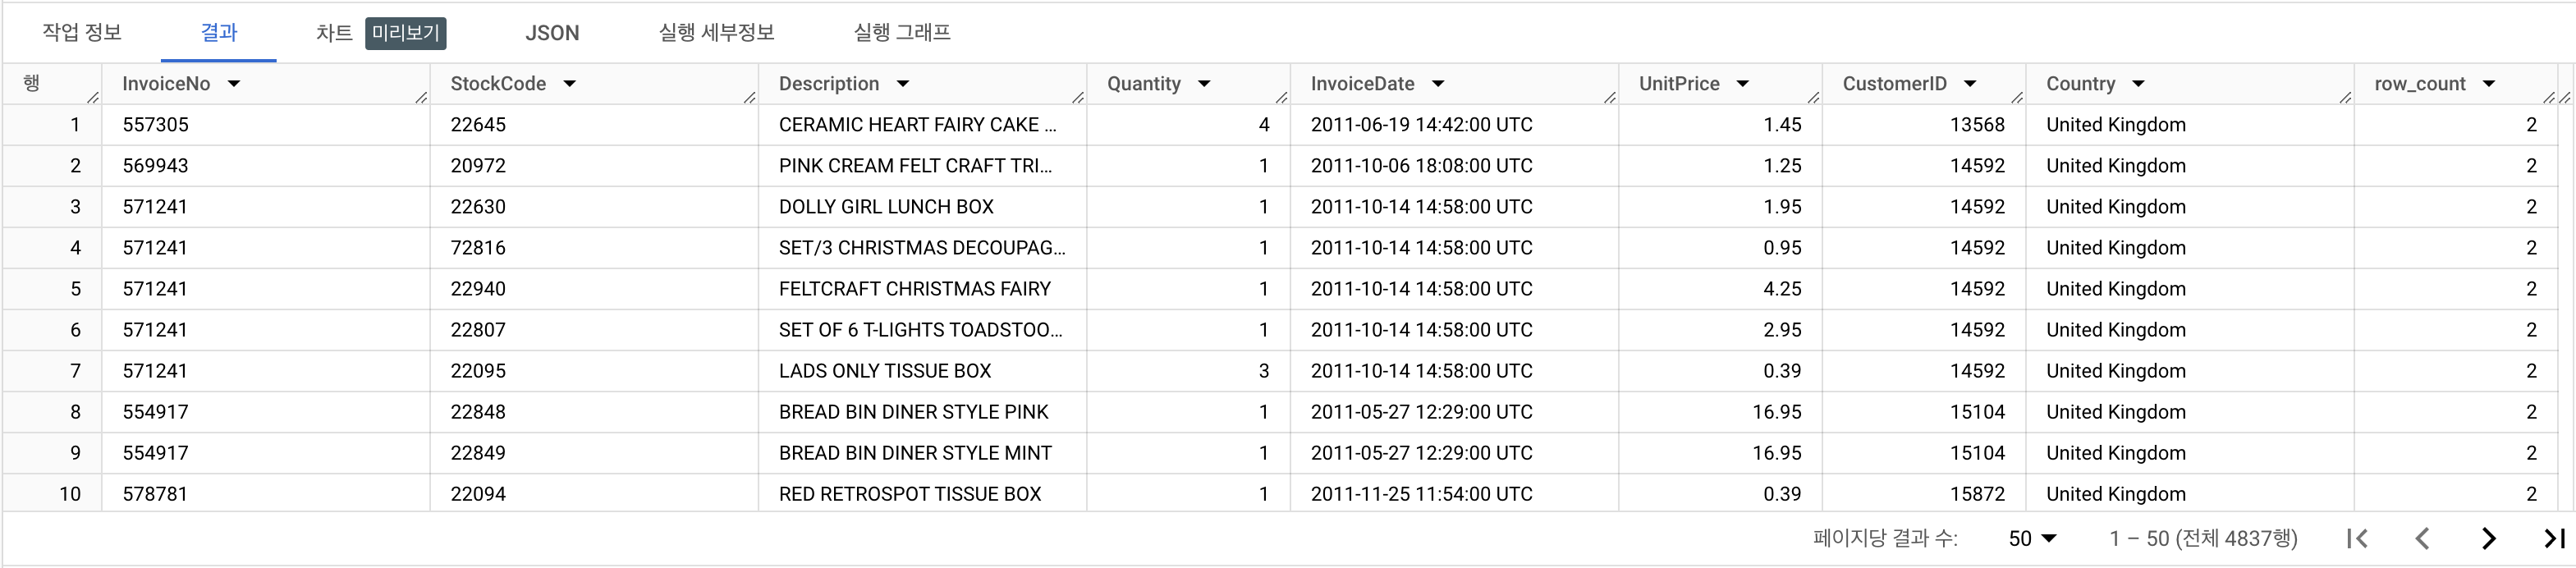

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS
SELECT DISTINCT *
FROM first-metric-410915.modulabs_project.data;

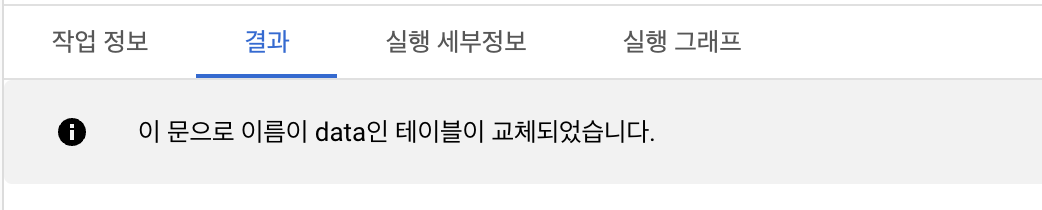

In [ ]:
SELECT COUNT(*) 
FROM first-metric-410915.modulabs_project.data;

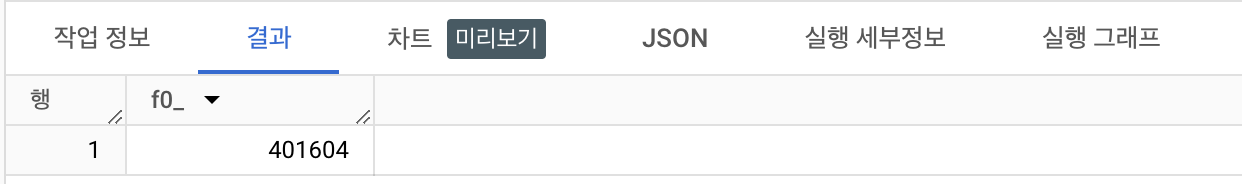

In [ ]:
SELECT COUNT(DISTINCT InvoiceNo) 
FROM first-metric-410915.modulabs_project.data;

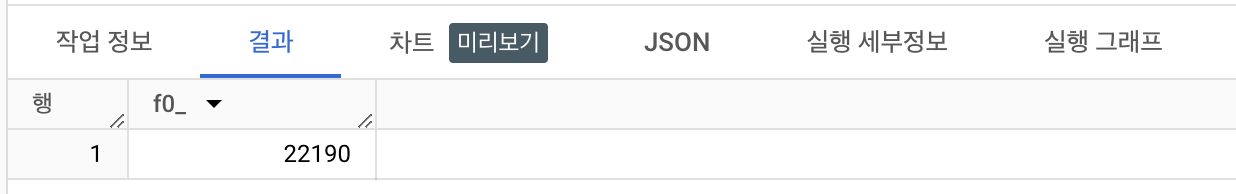

In [ ]:
SELECT DISTINCT InvoiceNo
FROM first-metric-410915.modulabs_project.data
LIMIT 100

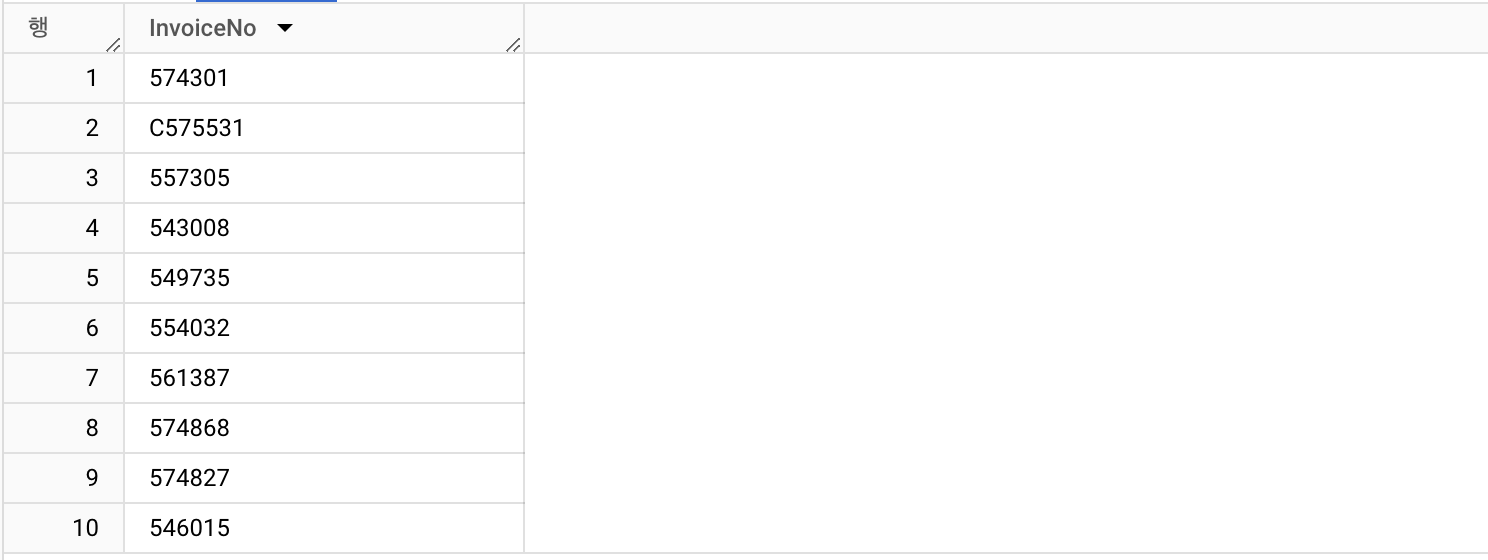

In [ ]:
SELECT *
FROM first-metric-410915.modulabs_project.data
WHERE InvoiceNo LIKE 'C%'
LIMIT 100

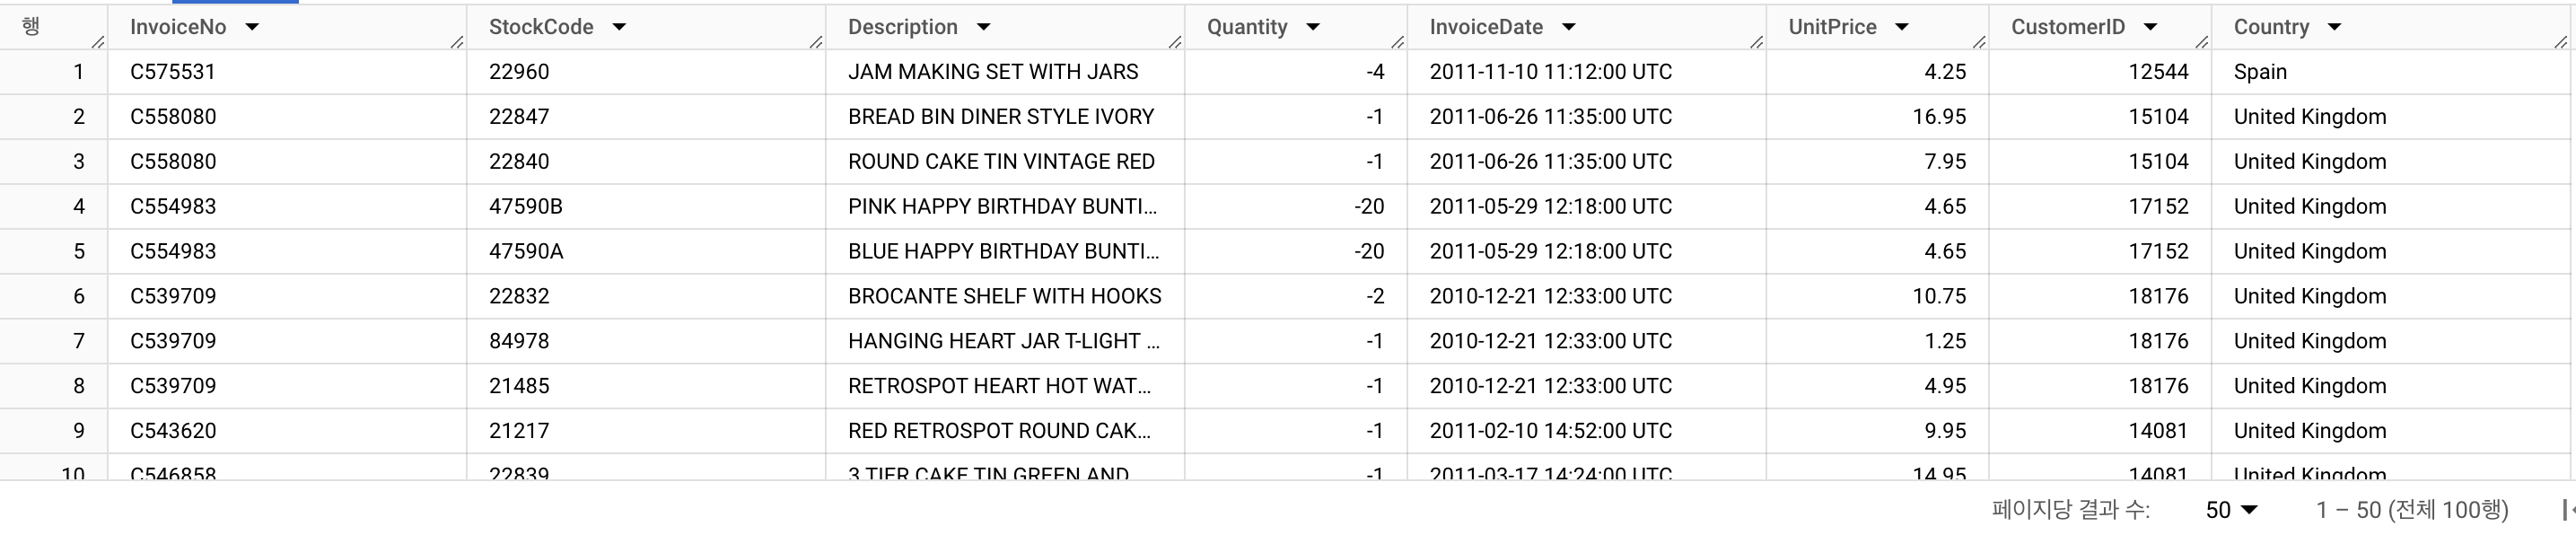

여기서 발견할 수 있는 특이한 경향성
100건 중 2 건 제외 전부 United Kingdom 에서 구매한 데이터 => 단순히 취소 데이터가 많은 건지 애초에 그 국가에서 많이 이용하는 건지 확인해봐야 함 <Br/>Quantity가 음수
전체 취소건은 8872건인데 이 중 취소한 물품은 3654 종류 여러 고객이 구매 취소하는 몇몇 물품들이 몰려 있을 가능성 있따.

In [ ]:
SELECT concat(ROUND(SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END)/ COUNT(InvoiceNo) * 100, 1), "%") as cancellations
FROM first-metric-410915.modulabs_project.data;

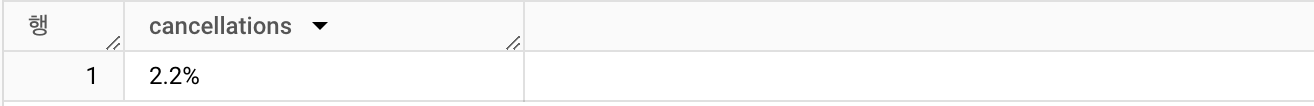

In [ ]:
SELECT COUNT(DISTINCT StockCode) 
FROM first-metric-410915.modulabs_project.data

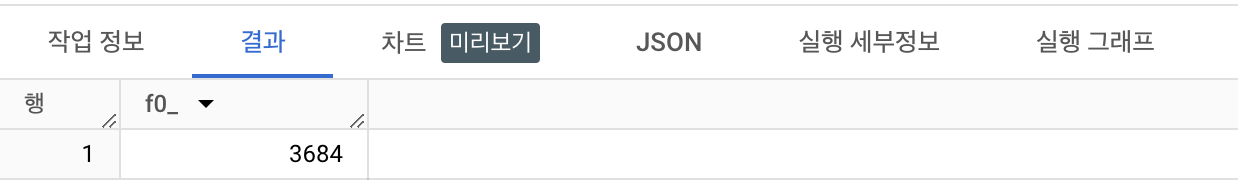

In [ ]:
SELECT StockCode, COUNT(*) AS sell_cnt 
FROM first-metric-410915.modulabs_project.data
GROUP BY 1
ORDER BY sell_cnt DESC
LIMIT 10

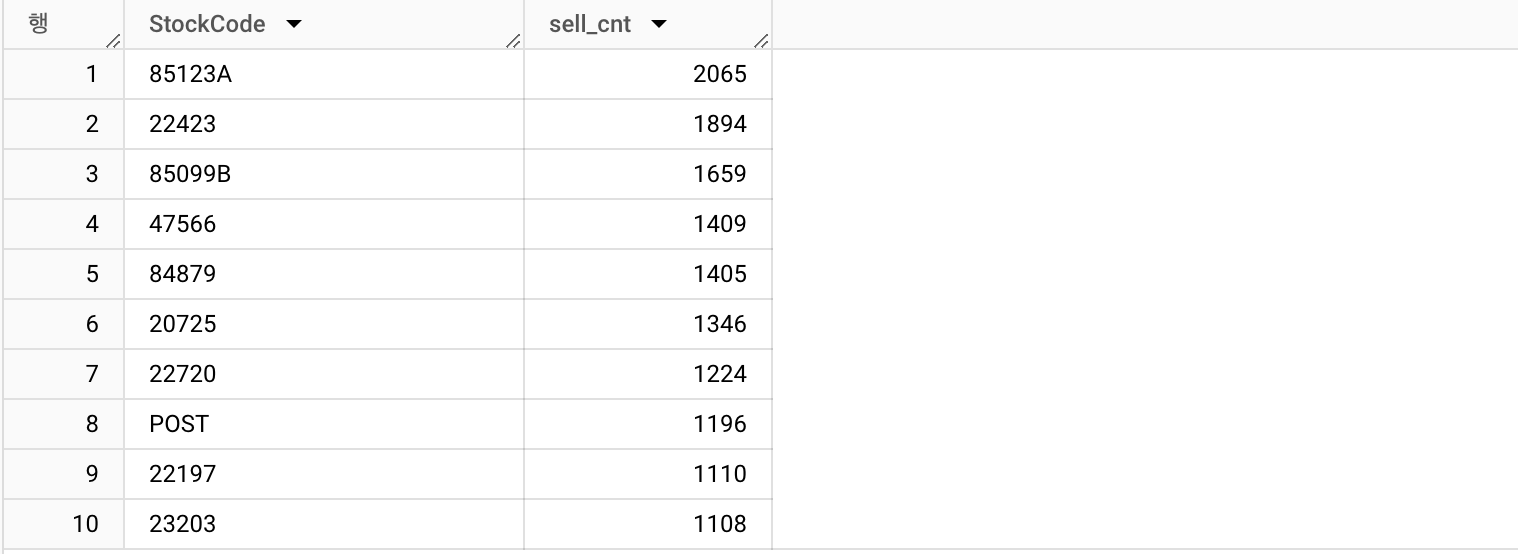

StockCode 자체만 봤을 때는 파악하기 어렵다. 그치만 다른 코드와 다른 A, B가 붙은 1,3행이나 POST가 뭔지 확인해봐야할 것 같다 
즉, 5~6자리 숫자로 되어있는데 POST 나 A,B는 뭘 뜻하는지 알아야 할 듯 싶다
<br/>
대부분의 StockCode들은 5-6 자리 숫자입니다. StockCode 중 'POST'는 이상치 같아 보입니다.



In [ ]:
WITH UniqueStockCodes AS (
  SELECT DISTINCT StockCode
  FROM first-metric-410915.modulabs_project.data
)
SELECT
  LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count,
  COUNT(*) AS stock_cnt
FROM UniqueStockCodes
GROUP BY number_count
ORDER BY stock_cnt DESC;

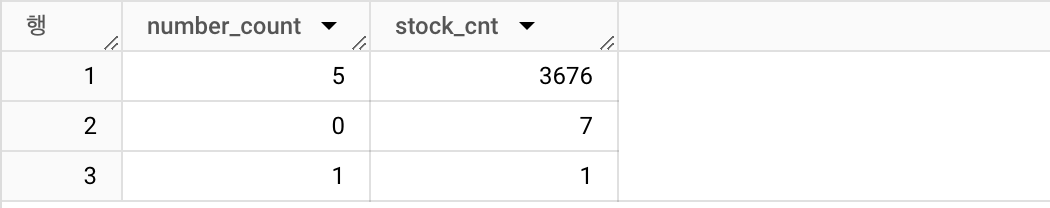

In [ ]:
SELECT DISTINCT StockCode, number_count
FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM first-metric-410915.modulabs_project.data
) 
WHERE number_count = 0 OR number_count = 1

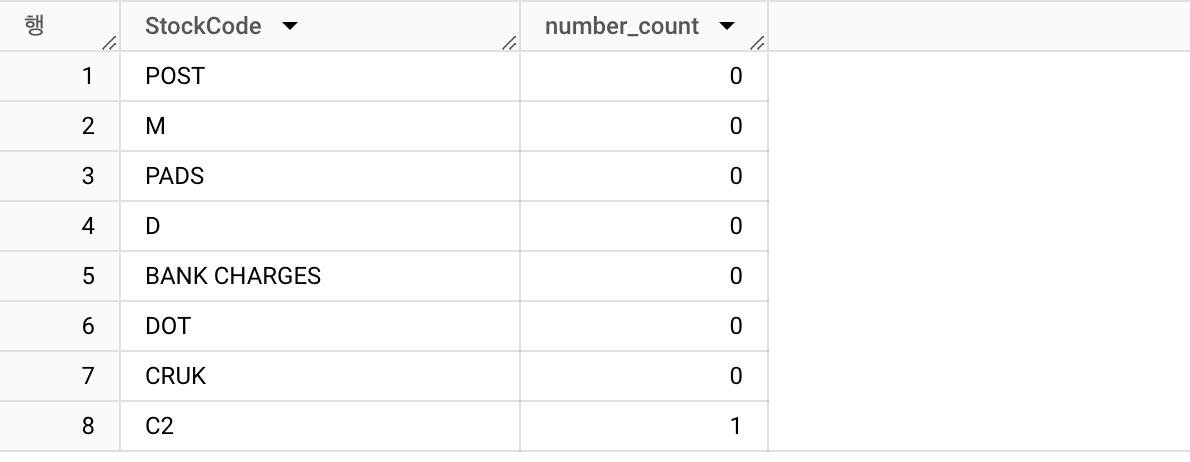

In [ ]:
SELECT concat(ROUND(SUM(CASE WHEN StockCode IN ('POST', 'M', 'PADS', 'D', 'BANK CHARGES', 'DOT', 'CRUK', 'C2') 
                        THEN 1 ELSE 0 END)/ COUNT(StockCode) * 100, 2), "%") as abnormal_StockCode
FROM first-metric-410915.modulabs_project.data

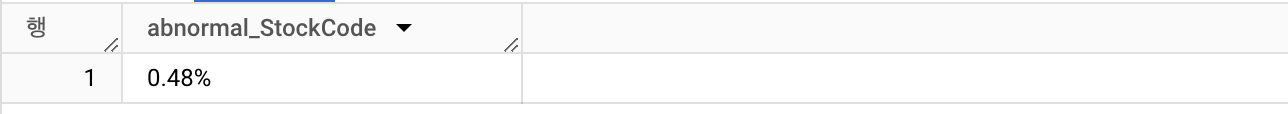

In [ ]:
DELETE FROM first-metric-410915.modulabs_project.data
WHERE StockCode IN (
  SELECT DISTINCT StockCode
  FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM first-metric-410915.modulabs_project.data
  ) 
WHERE number_count = 0 OR number_count = 1
)

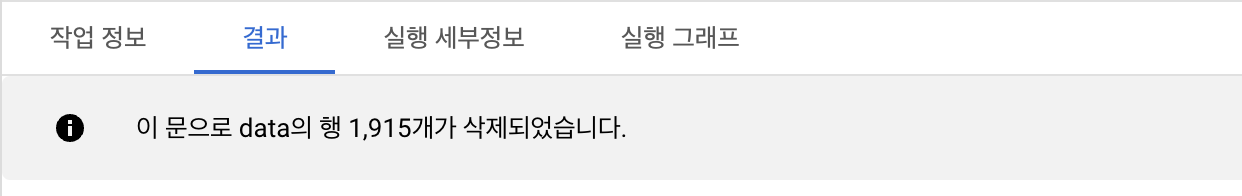

In [ ]:
SELECT Description, COUNT(*) AS description_cnt
FROM first-metric-410915.modulabs_project.data
GROUP BY 1
ORDER BY 2 DESC
LIMIT 30

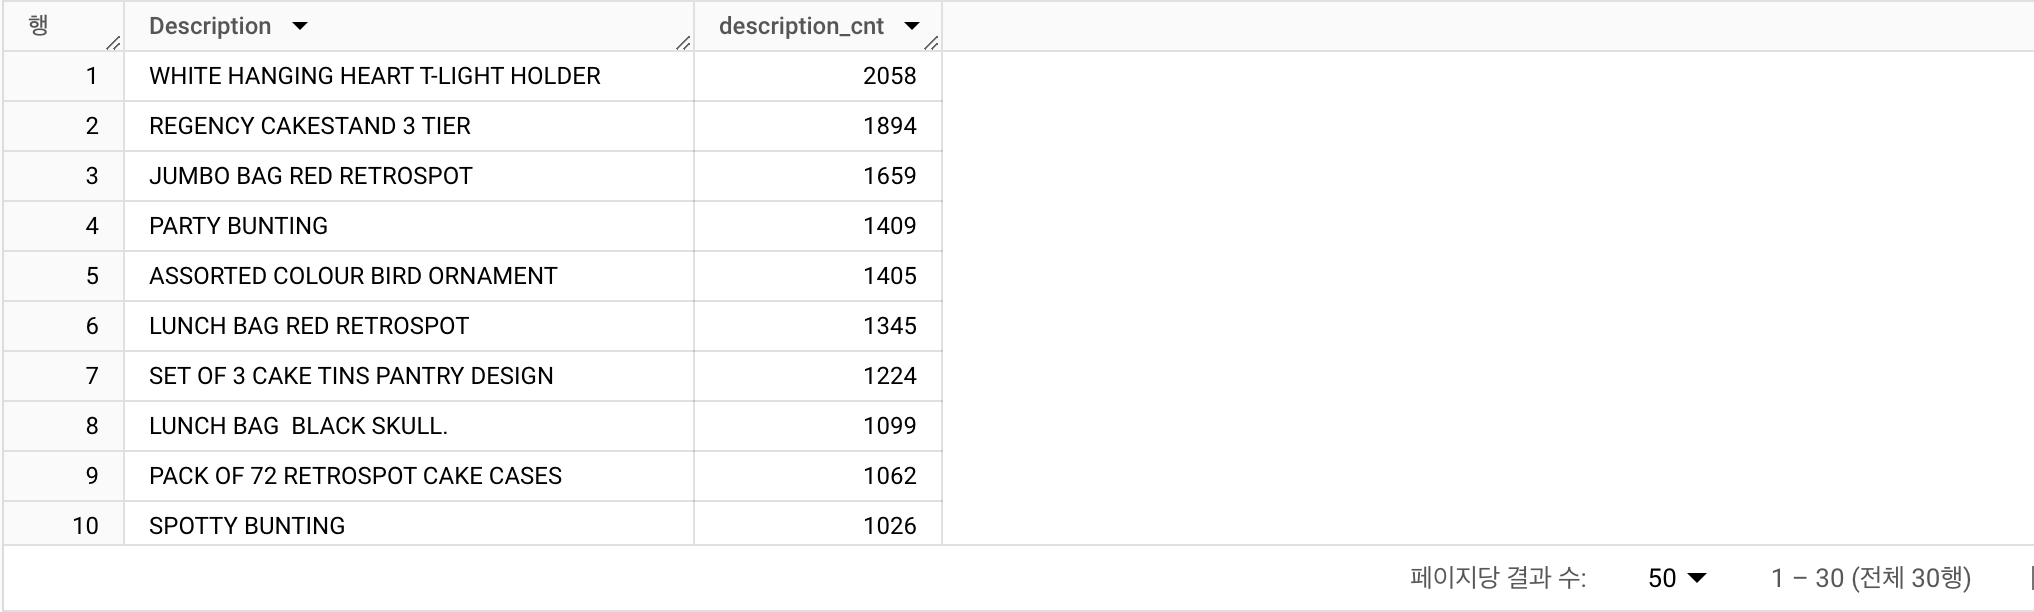

In [ ]:
SELECT DISTINCT Description
FROM first-metric-410915.modulabs_project.data
WHERE REGEXP_CONTAINS(Description, r'[a-z]')

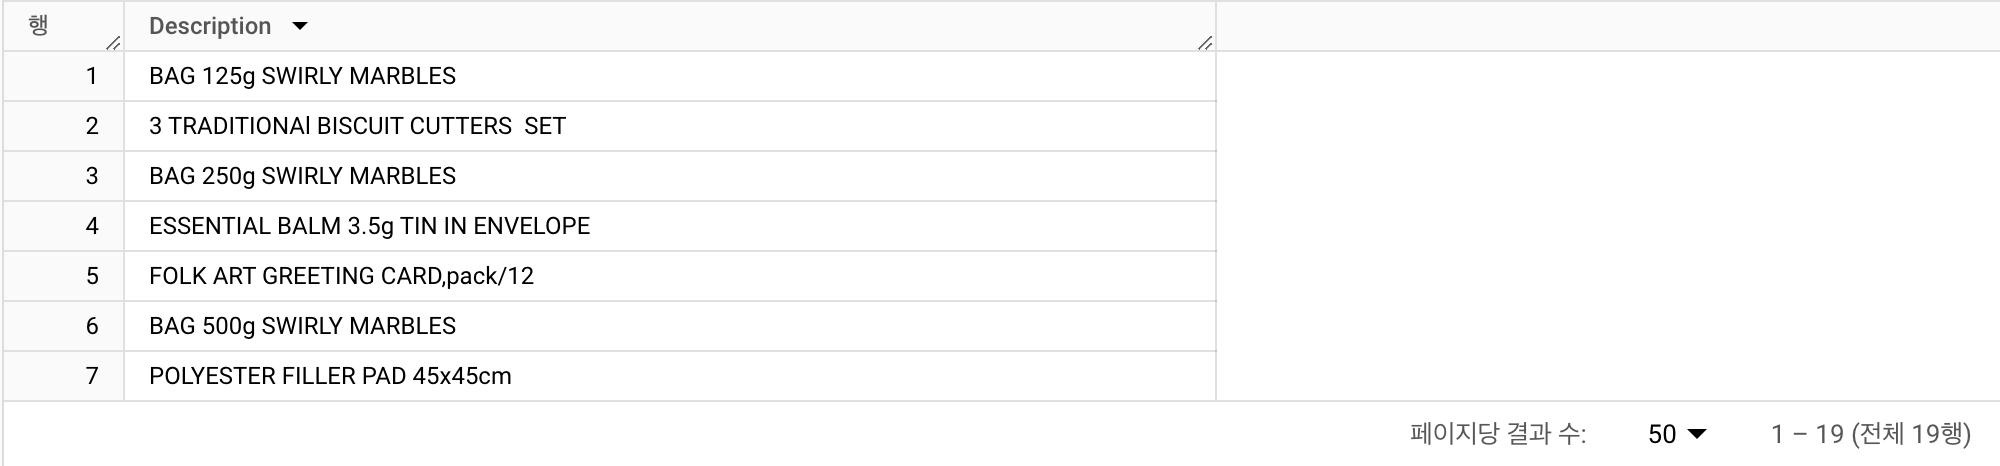

In [ ]:
DELETE
FROM first-metric-410915.modulabs_project.data
WHERE Description IN ('Next Day Carriage', 'High Resolution Image')

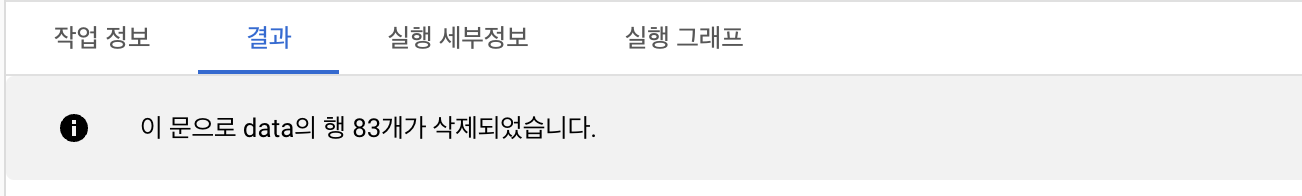

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS
SELECT
  * EXCEPT (Description),
  UPPER(Description) AS Description
FROM first-metric-410915.modulabs_project.data

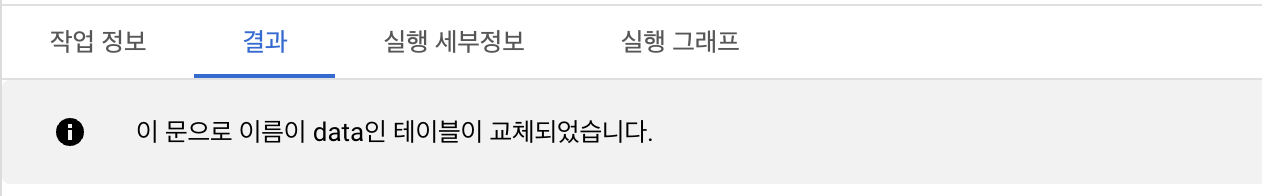

In [ ]:
select * FROM first-metric-410915.modulabs_project.data_updated WHERE InvoiceNo = '560538'

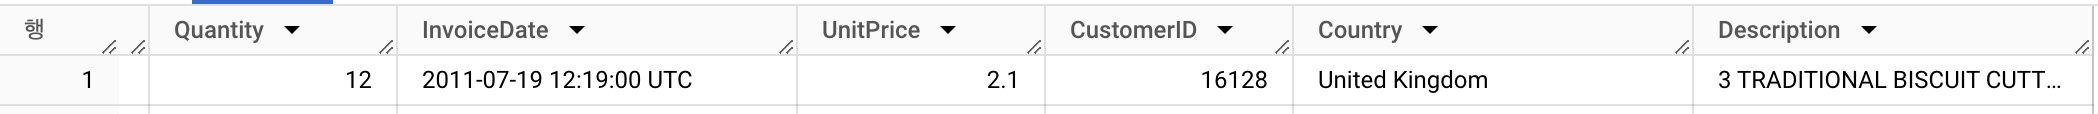

In [ ]:
SELECT COUNT(UnitPrice) AS cnt_quantity, MIN(Quantity) AS min_quantity, MAX(Quantity) AS max_quantity
, AVG(Quantity) AS avg_quantity
FROM first-metric-410915.modulabs_project.data
WHERE UnitPrice = 0

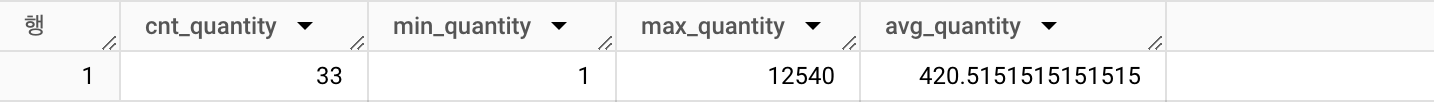

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS 
SELECT *
FROM first-metric-410915.modulabs_project.data
WHERE UnitPrice = 0

399606 => 399573 (399606-33)

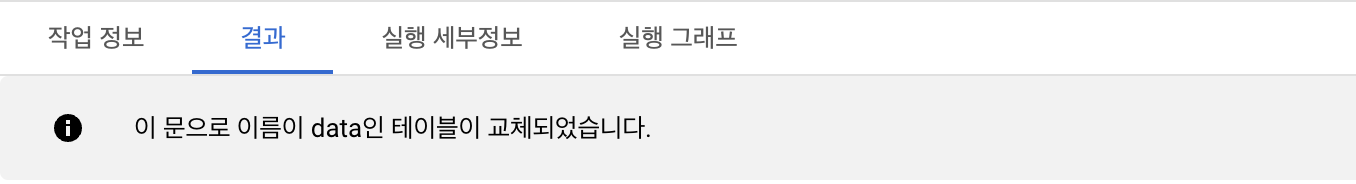

## 15-7. RFM 스코어

### Recency

In [ ]:
SELECT *
FROM first-metric-410915.modulabs_project.data;

CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS
SELECT
  * EXCEPT (InvoiceDate),
  DATE(InvoiceDate) AS InvoiceDate
FROM first-metric-410915.modulabs_project.data;

SELECT *
FROM first-metric-410915.modulabs_project.data;

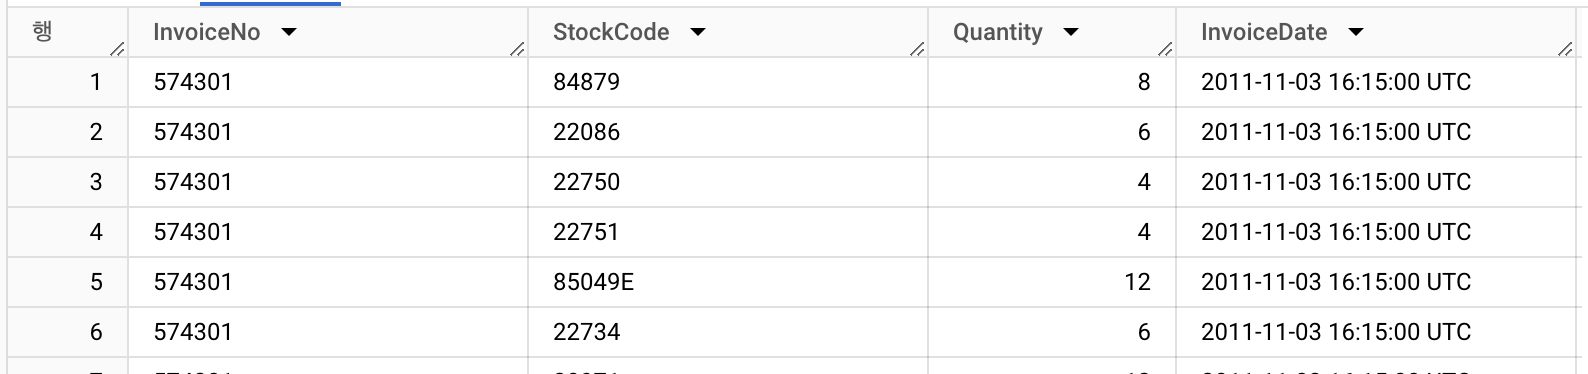
🔼 변경 전

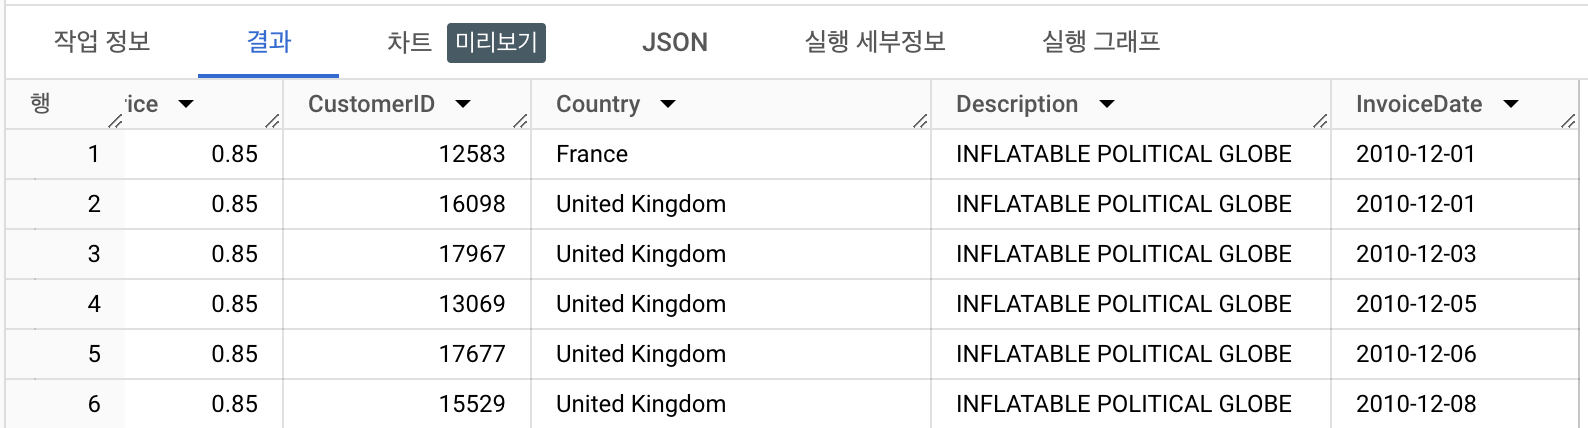
🔼 변경 후

In [ ]:
SELECT
    MAX(InvoiceDate) OVER () AS most_recent_date,
    InvoiceDate AS InvoiceDay,
    *
FROM first-metric-410915.modulabs_project.data;

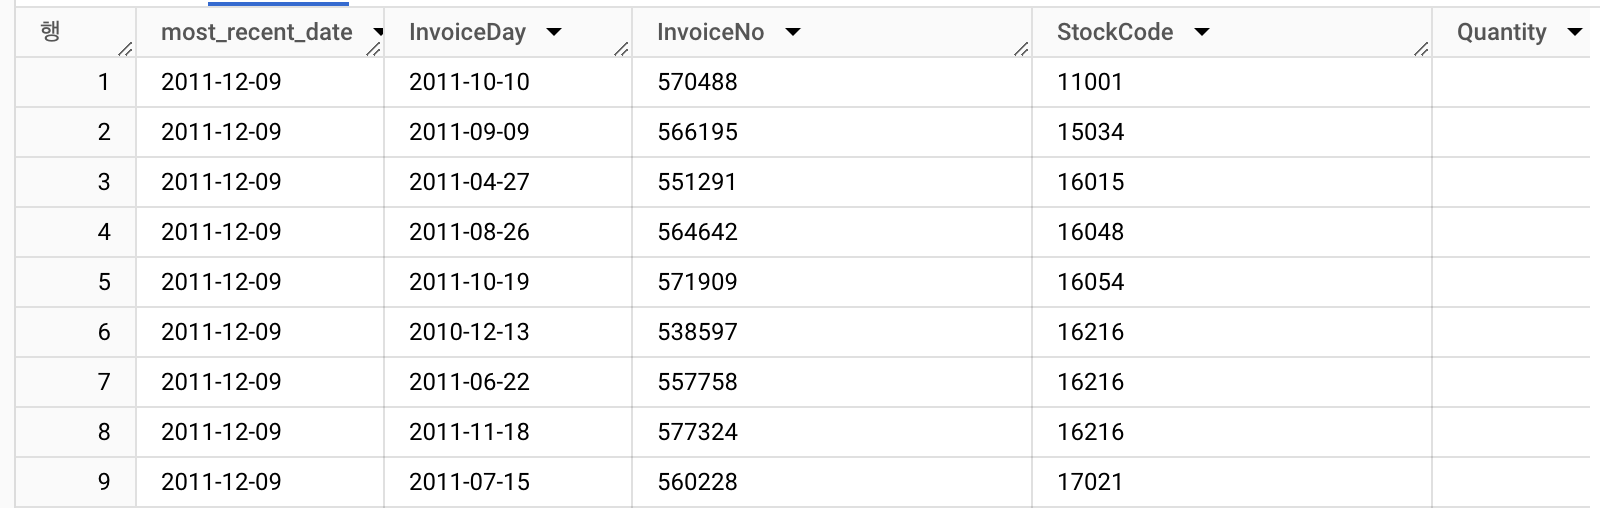

In [ ]:
SELECT
    CustomerID,
    MAX(InvoiceDate) AS InvoiceDay
FROM first-metric-410915.modulabs_project.data
GROUP BY 1
ORDER BY 1;

SELECT
    DISTINCT CustomerID,
    MAX(InvoiceDate) OVER (PARTITION BY CustomerID) AS InvoiceDay
FROM first-metric-410915.modulabs_project.data
ORDER BY 1;

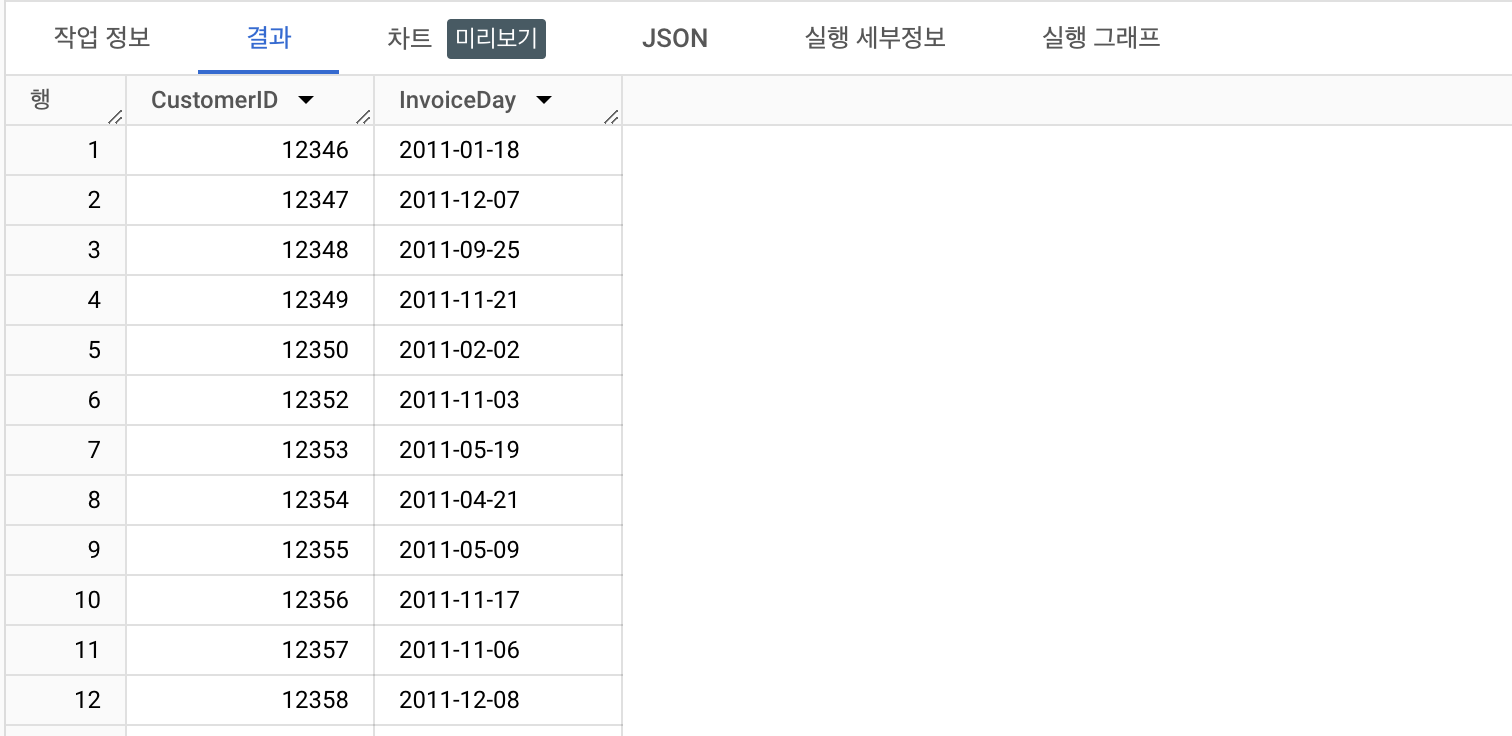

In [ ]:
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)ORDER BY 1;

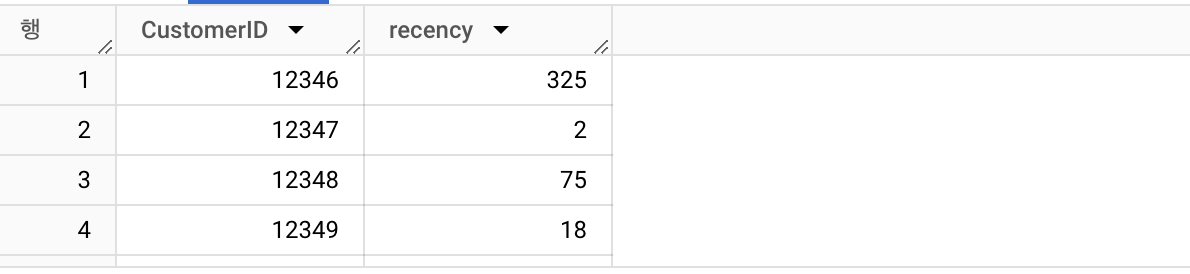

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_r AS
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)

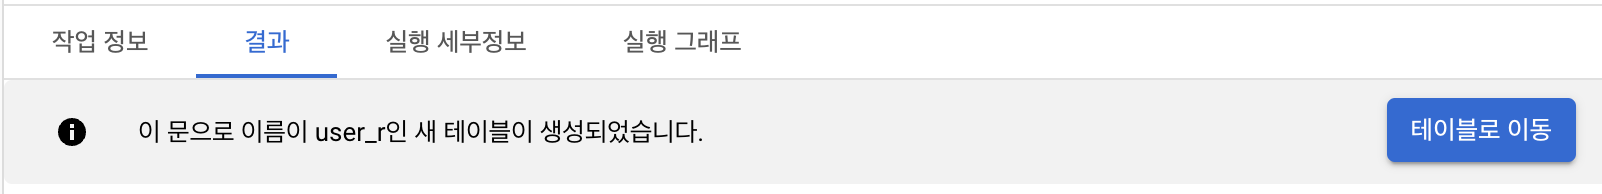

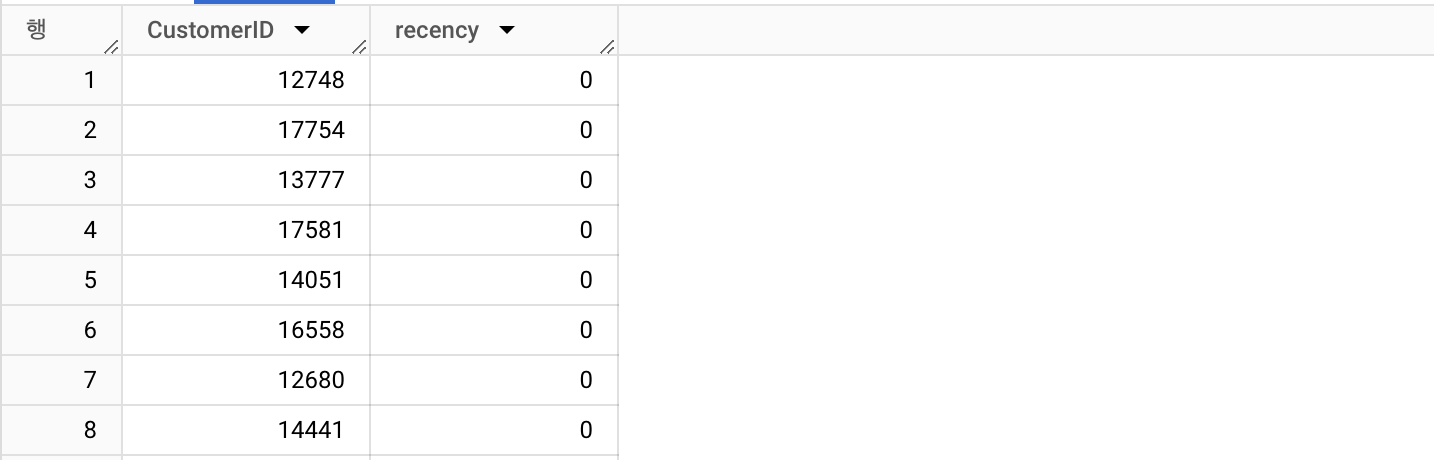
🔼 데이터 user_r

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_rf AS
-- (1) 전체 거래 건수 계산
WITH purchase_cnt AS ( 
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS purchase_cnt
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1
),
-- (2) 구매한 아이템 총 수량 계산
item_cnt AS (
  SELECT
    CustomerID,
    SUM(Quantity) AS item_cnt
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1
)
-- 기존의 user_r에 (1)과 (2)를 통합
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN first-metric-410915.modulabs_project.user_r AS ur
  ON pc.CustomerID = ur.CustomerID;

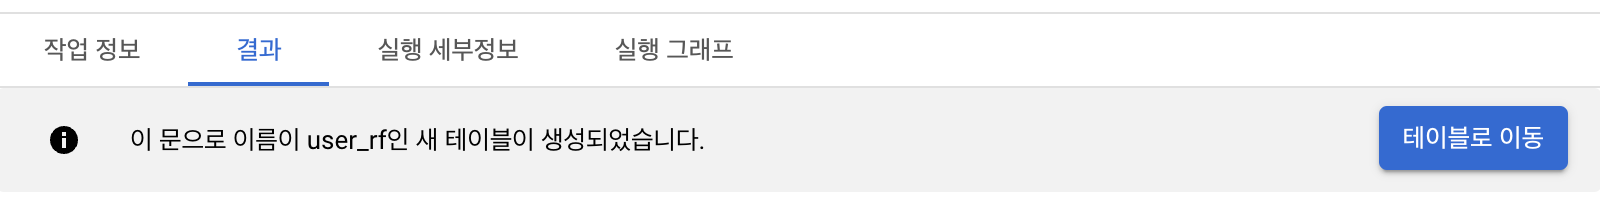

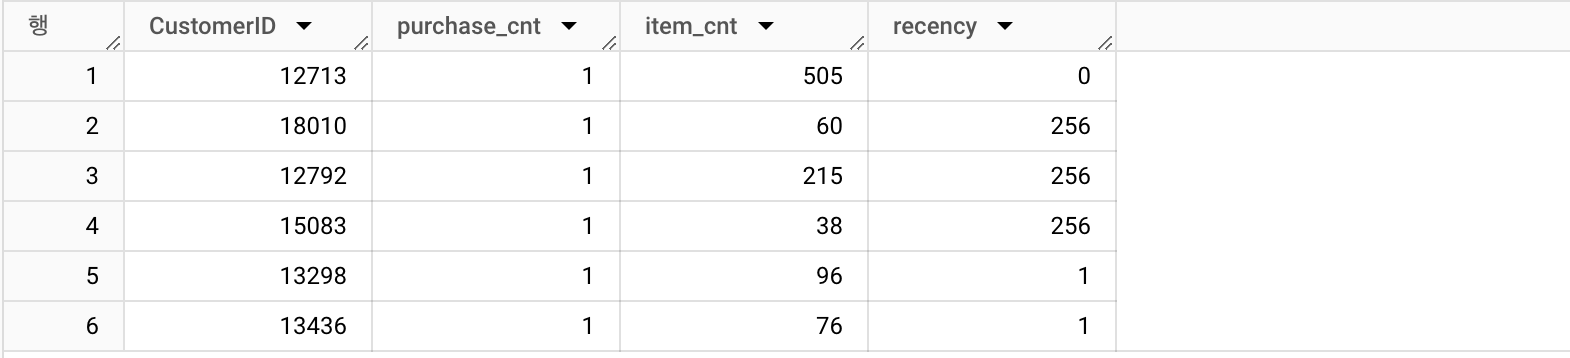
🔼 데이터 user_rf

### 1. 고객별 총 지출액 계산

In [ ]:
SELECT
  CustomerID,
  ROUND(SUM(Quantity * UnitPrice)) AS user_total
FROM first-metric-410915.modulabs_project.data
GROUP BY 1;

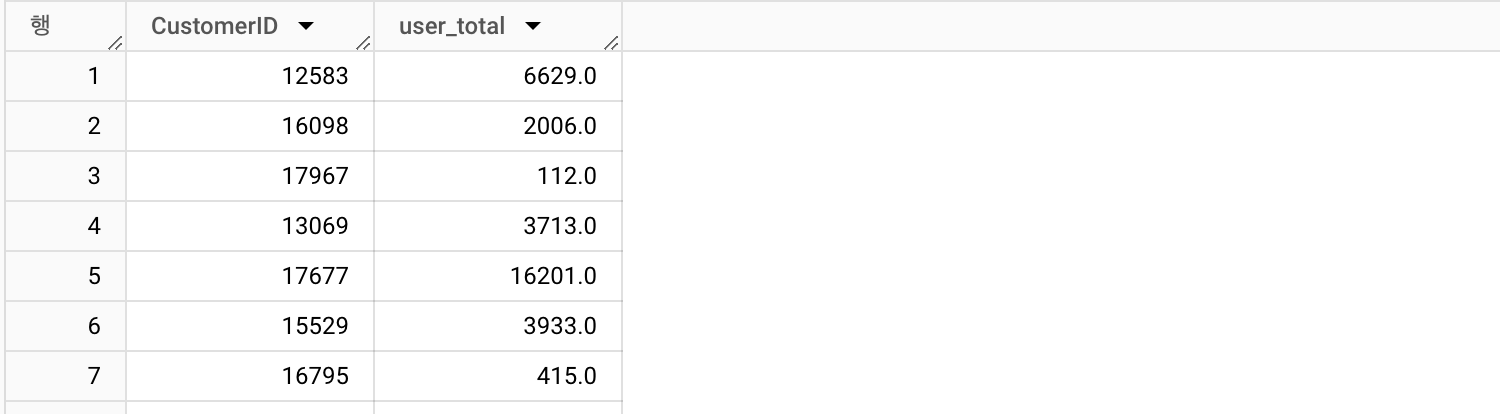

### 2. 고객별 평균 거래 금액 계산

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_rfm AS   
SELECT
  rf.CustomerID AS CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  ROUND(ut.user_total / rf.purchase_cnt) AS user_average
FROM first-metric-410915.modulabs_project.user_rf rf
LEFT JOIN (
  -- 고객 별 총 지출액
  SELECT
    CustomerID,
    ROUND(SUM(Quantity * UnitPrice)) AS user_total
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1
) ut
ON rf.CustomerID = ut.CustomerID;

SELECT *
FROM first-metric-410915.modulabs_project.user_rfm;

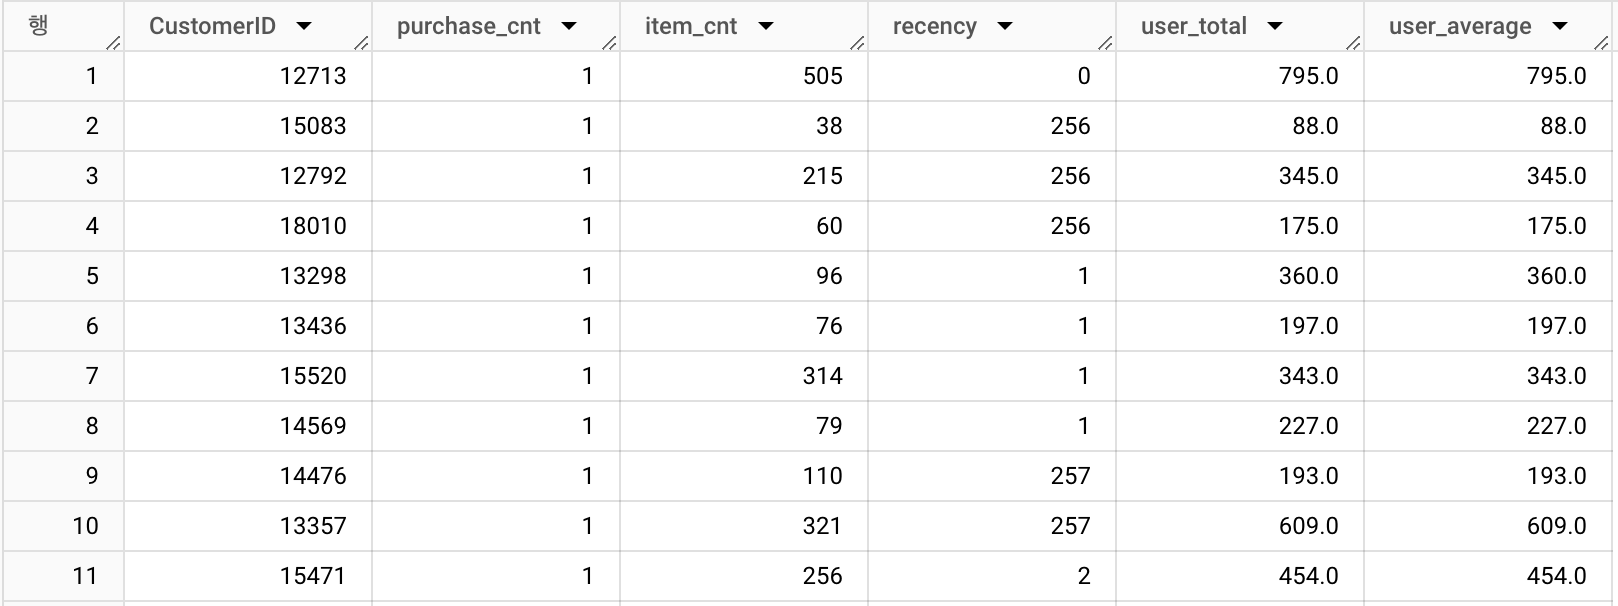
🔼 데이터 user_rfm

# 클러스터링 알고리즘

### 구매하는 제품의 다양성

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM first-metric-410915.modulabs_project.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;

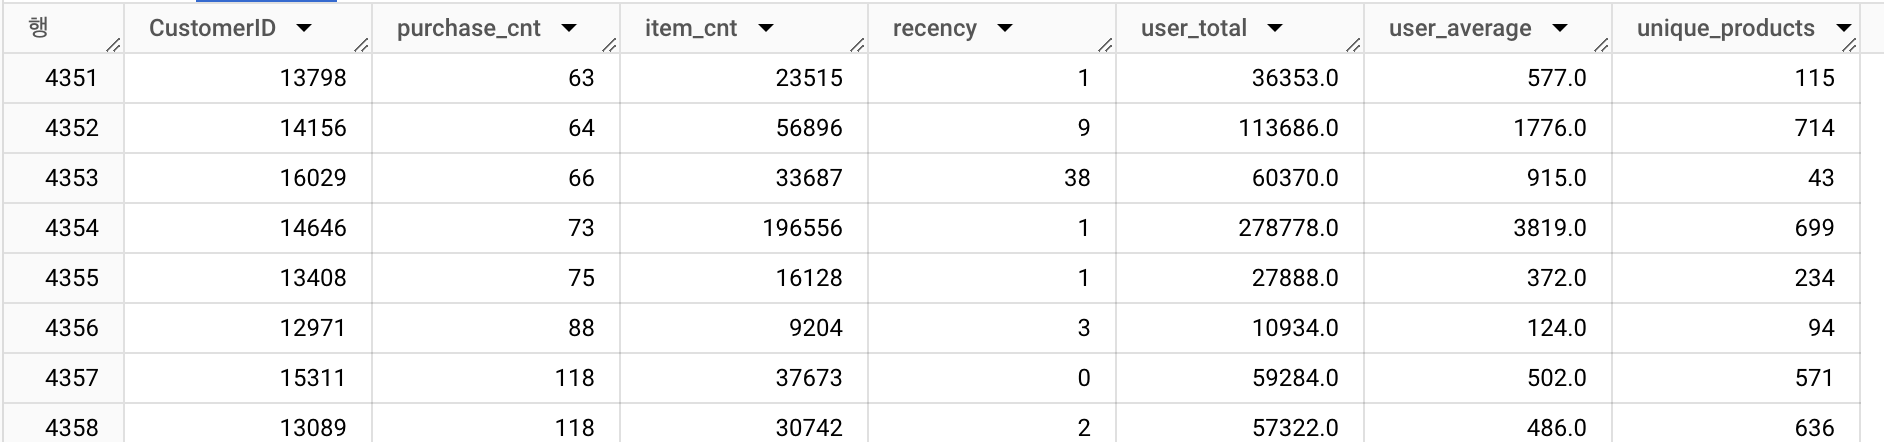
🔼 데이터 user_data

### 평균 구매 주기

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      first-metric-410915.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM first-metric-410915.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;


select * from first-metric-410915.modulabs_project.user_data

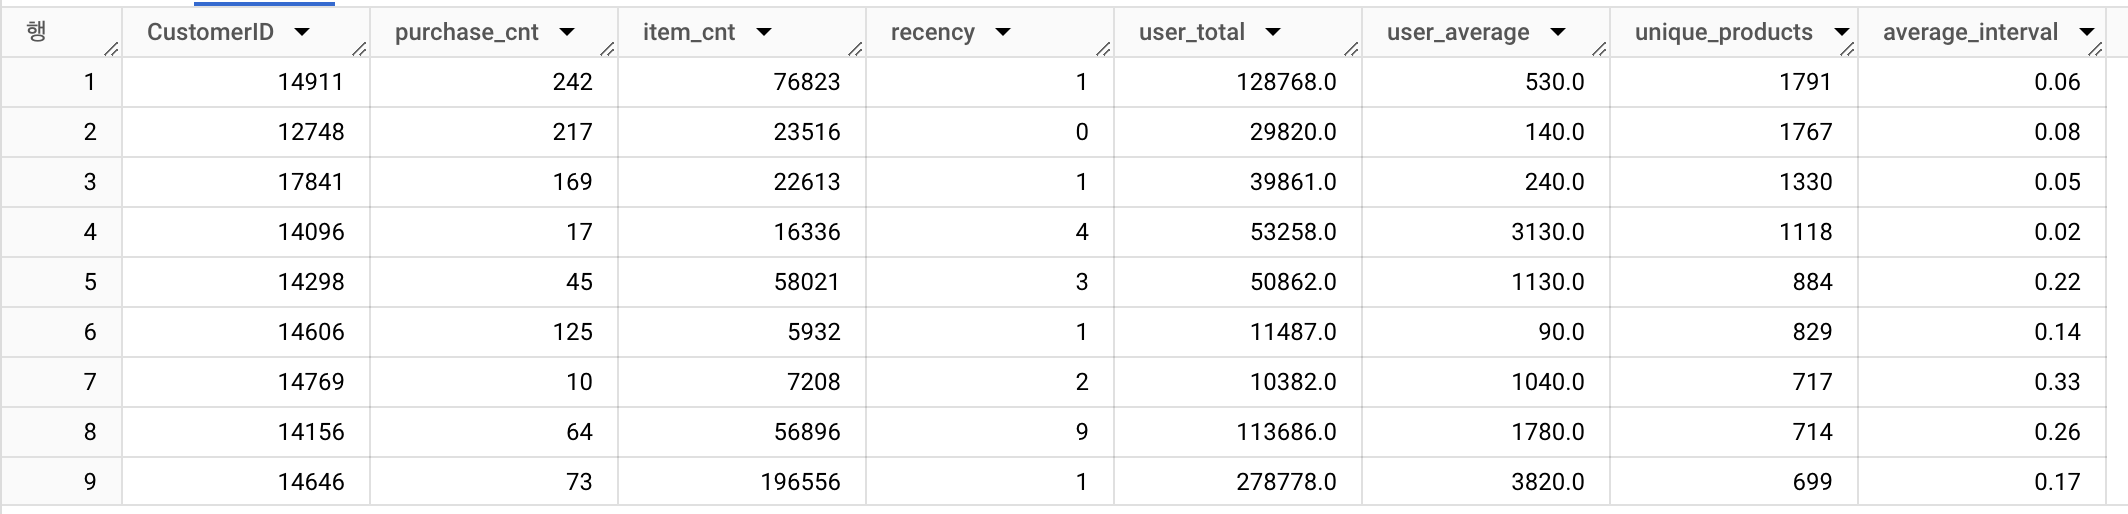
🔼 업데이트된 데이터 user_data

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS

WITH TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS total_transactions,
    COUNTIF(InvoiceNo LIKE 'C%') AS cancel_frequency
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)
SELECT u.*, t.* EXCEPT(CustomerID), ROUND(t.cancel_frequency / t.total_transactions * 100, 2) AS cancel_rate
FROM `first-metric-410915.modulabs_project.user_data` AS u
LEFT JOIN TransactionInfo AS t
ON u.CustomerID = t.CustomerID;

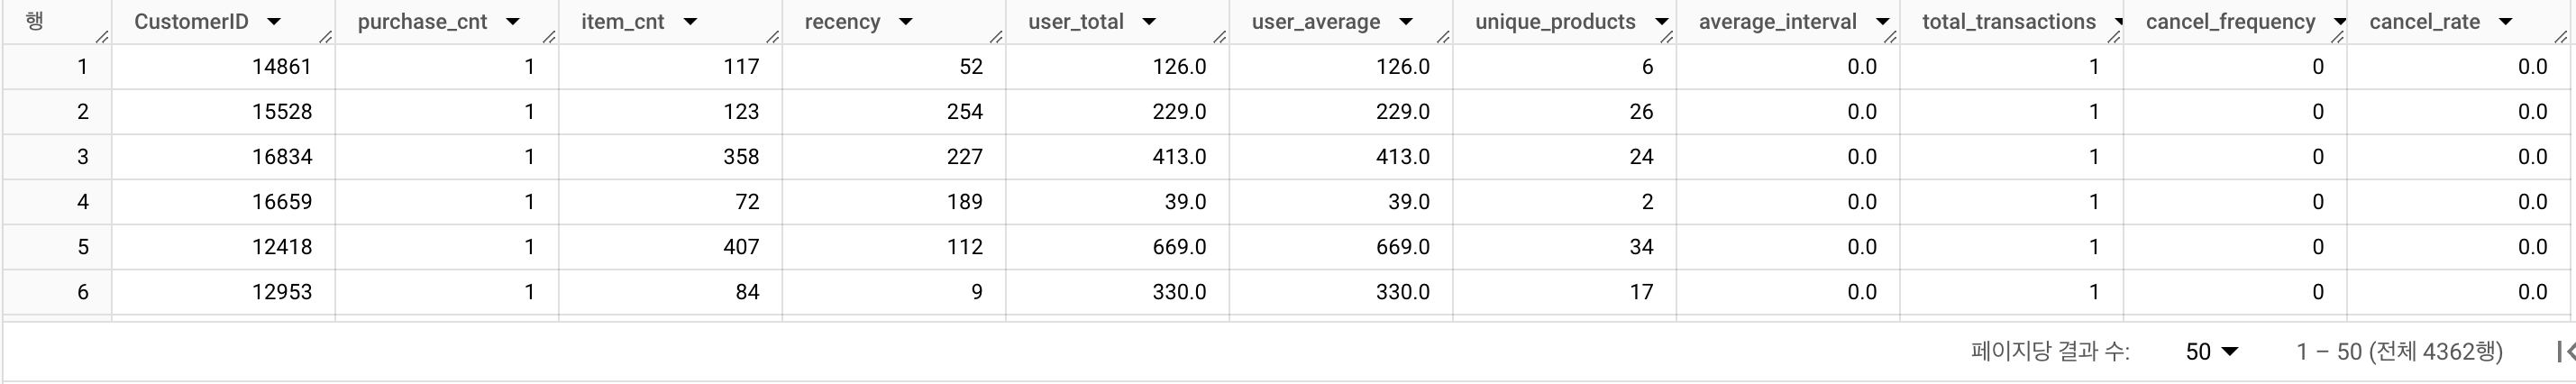
🔼 업데이트된 최종 데이터 user_data